In [1]:
import sklearn
import numpy as np
from numpy import ma
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import numpy.random as r
from sklearn.metrics import accuracy_score 

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow import keras

In [2]:
names =['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df = pd.read_csv('train.csv',header=None,sep=",",names=names, encoding = "ISO-8859-1")

names_test =['id', 'comment_text']
df_test = pd.read_csv('test.csv',header=None,sep=",",names=names_test, encoding = "ISO-8859-1")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df['toxic_score'] = df[['toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
#drop unnecessary columns
df = df.drop(['id', 'toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate'], axis=1)
#drop first row
df.drop(df.index[:1], inplace=True)

df_test = df_test.drop(['id'], axis=1)
df_test.drop(df_test.index[:1], inplace=True)
#df.drop(df.index[:150000], inplace=True) #smaller data set

In [4]:
# print(df)

In [5]:
df.head(5)
df_test.head(5)

,comment_text
1,Yo bitch Ja Rule is more succesful then you'll...
2,== From RfC == \n\n The title is fine as it is...
3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
4,":If you have a look back at the source, the in..."
5,I don't anonymously edit articles at all.


In [6]:
bad_words = []
negative_file = open("negative-words.txt", "r")
for line in negative_file:
    bad_words.append(line.strip("\n"))
negative_file.close()
profanity_file = open("profanity-words.txt", "r")
for line in profanity_file:
    if (line.strip("\n") not in bad_words):
        bad_words.append(line.strip("\n"))
profanity_file.close()
# print(bad_words)

In [7]:
# because we have a lot of features, scaling the data set size down to 3000

data = df.values

X = data[:,0].reshape((159571,1))
Y = data[:,1].reshape((159571,1))

toxic_count = 0
not_toxic_count = 0
val_toxic = 0
val_not_toxic = 0
test_count = 0

X_training = []
Y_training = []
X_validation = []
Y_validation = []
X_testing = []
Y_testing = []

data_size = 15000

for index in range(0,159571):
    if ((int(Y[index][0]) == 1 and toxic_count < 0.5 * data_size) or 
        (int(Y[index][0]) == 0 and not_toxic_count < 0.5 * data_size)):
        Y_training.append(int(Y[index][0]))
        X_training.append(X[index][0])
        if (int(Y[index][0]) == 1):
            toxic_count += 1
        else:
            not_toxic_count += 1
    else:
        if ((int(Y[index][0]) == 1 and val_toxic < 0.5 * data_size) or 
            (int(Y[index][0]) == 0 and val_not_toxic < 0.5 * data_size)):
            Y_validation.append(int(Y[index][0]))
            X_validation.append(X[index][0])
            if (int(Y[index][0]) == 1):
                val_toxic += 1
            else:
                val_not_toxic += 1
        else:
            if(test_count < data_size * 2):
                Y_testing.append(int(Y[index][0]))
                X_testing.append(X[index][0])
                test_count += 1
    if (toxic_count + not_toxic_count == data_size and 
        val_toxic + val_not_toxic == data_size and 
        test_count == data_size * 2):
        break
                
# X_tr = np.array(X_tr).reshape((15000, 1))
Y_train = np.array(Y_training).reshape((data_size, 1))
Y_test = np.array(Y_testing).reshape((data_size * 2, 1))
Y_val = np.array(Y_validation).reshape((data_size, 1))


cv = sklearn.feature_extraction.text.CountVectorizer(vocabulary=bad_words)
X_train = cv.fit_transform(X_training).toarray()
X_test = cv.fit_transform(X_testing).toarray()
X_val = cv.fit_transform(X_validation).toarray()

# Neural Networks Not Scaled - Sigmoid

In [8]:
#using tensorflow to make the neural network
num_features = len(bad_words)

model = keras.Sequential()
model.add(keras.layers.Dense(units=num_features, input_shape=(num_features,)))
model.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid))
model.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid))
model.add(keras.layers.Dense(units=1, activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5213)              27180582  
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              7821000   
_________________________________________________________________
dense_2 (Dense)              (None, 1500)              2251500   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1501      
Total params: 37,254,583
Trainable params: 37,254,583
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [10]:
training = model.fit(X_train,
                    Y_train,
                    epochs=30,
                    batch_size=500,
                    validation_data=(X_val, Y_val),
                    verbose=1)

Train on 15000 samples, validate on 15000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
15000/15000 [==============================] - 30s 2ms/sample - loss: 0.8821 - acc: 0.6425 - val_loss: 0.3690 - val_acc: 0.8563
Epoch 2/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.3440 - acc: 0.8739 - val_loss: 0.3725 - val_acc: 0.8566
Epoch 3/30
15000/15000 [==============================] - 31s 2ms/sample - loss: 0.3016 - acc: 0.8917 - val_loss: 0.3866 - val_acc: 0.8563
Epoch 4/30
15000/15000 [==============================] - 31s 2ms/sample - loss: 0.2885 - acc: 0.8937 - val_loss: 0.3920 - val_acc: 0.8570
Epoch 5/30
15000/15000 [==============================] - 30s 2ms/sample - loss: 0.2789 - acc: 0.8975 - val_loss: 0.4023 - val_acc: 0.8545
Epoch 6/30
15000/15000 [==============================] - 30s 2ms/sample - loss: 0.2748 - acc: 0.8994 - val_loss: 0.4009 - val_acc: 0.8554
Epoch 7/30
15000/15000 [==============================] - 29s 2ms/sa

In [11]:
results = model.evaluate(X_test, Y_test)
print(results)

30000/30000 [==============================] - 23s 762us/sample - loss: 0.4588 - acc: 0.9144
[0.4587731474518776, 0.91443336]


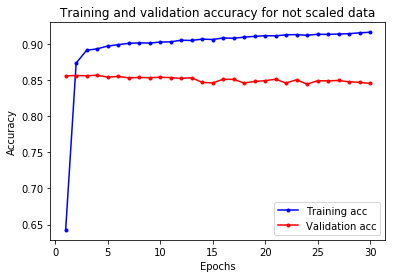

In [12]:
training_hist = training.history
train_acc = training_hist['acc']
val_acc = training_hist['val_acc']
plt.figure()   
num_epochs = range(1, len(train_acc) + 1)
plt.plot(num_epochs, train_acc, 'b.-', label='Training acc')
plt.plot(num_epochs, val_acc, 'r.-', label='Validation acc')
plt.title('Training and validation accuracy for not scaled data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [13]:
# create neural network

# Neural Networks Scaling - Sigmoid

In [14]:
X_scale = StandardScaler()
X_tr = X_scale.fit_transform(X_train)
X_te = X_scale.fit_transform(X_test)
X_va = X_scale.fit_transform(X_val)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by Stand

In [15]:
model_scale = keras.Sequential()
model_scale.add(keras.layers.Dense(units=num_features, input_shape=(num_features,)))
model_scale.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid))
model_scale.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid))
model_scale.add(keras.layers.Dense(units=1, activation=tf.nn.sigmoid))
model_scale.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['acc'])
model_scale.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 5213)              27180582  
_________________________________________________________________
dense_5 (Dense)              (None, 1500)              7821000   
_________________________________________________________________
dense_6 (Dense)              (None, 1500)              2251500   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1501      
Total params: 37,254,583
Trainable params: 37,254,583
Non-trainable params: 0
_________________________________________________________________


In [16]:
train_scale = model_scale.fit(X_tr,
                              Y_train, 
                              epochs=30, 
                              batch_size=500, 
                              validation_data=(X_va, Y_val), 
                              verbose=1)

Train on 15000 samples, validate on 15000 samples
Epoch 1/30
15000/15000 [==============================] - 33s 2ms/sample - loss: 0.9162 - acc: 0.6145 - val_loss: 0.5771 - val_acc: 0.7013
Epoch 2/30
15000/15000 [==============================] - 31s 2ms/sample - loss: 0.4674 - acc: 0.7894 - val_loss: 0.5545 - val_acc: 0.7253
Epoch 3/30
15000/15000 [==============================] - 30s 2ms/sample - loss: 0.4167 - acc: 0.8145 - val_loss: 0.5831 - val_acc: 0.7351
Epoch 4/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.3792 - acc: 0.8367 - val_loss: 0.5788 - val_acc: 0.7495
Epoch 5/30
15000/15000 [==============================] - 30s 2ms/sample - loss: 0.3576 - acc: 0.8452 - val_loss: 0.7465 - val_acc: 0.7342
Epoch 6/30
15000/15000 [==============================] - 31s 2ms/sample - loss: 0.3413 - acc: 0.8565 - val_loss: 0.6622 - val_acc: 0.7449
Epoch 7/30
15000/15000 [==============================] - 30s 2ms/sample - loss: 0.3154 - acc: 0.8701 - val_loss: 0.

In [19]:
results = model_scale.evaluate(X_te, Y_test)
print(results)

30000/30000 [==============================] - 24s 789us/sample - loss: 3.2830 - acc: 0.2852
[3.2830106524149576, 0.2852]


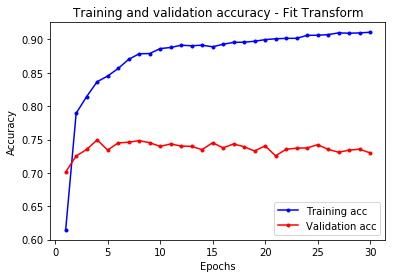

In [20]:
train_hist_scale = train_scale.history
train_acc_scale = train_hist_scale['acc']
val_acc_scale = train_hist_scale['val_acc']
plt.figure()   
num_epochs_scale = range(1, len(train_acc_scale) + 1)
plt.plot(num_epochs_scale, train_acc_scale, 'b.-', label='Training acc')
plt.plot(num_epochs_scale, val_acc_scale, 'r.-', label='Validation acc')
plt.title('Training and validation accuracy - Fit Transform')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Neural Network - Normalized Data

In [10]:
X_tr_norm = preprocessing.normalize(X_train)
X_te_norm = preprocessing.normalize(X_test)
X_va_norm = preprocessing.normalize(X_val)

In [12]:
num_features = len(bad_words)
model_norm = keras.Sequential()
model_norm.add(keras.layers.Dense(units=num_features, input_shape=(num_features,)))
model_norm.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid))
model_norm.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid))
model_norm.add(keras.layers.Dense(units=1, activation=tf.nn.sigmoid))
model_norm.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['acc'])
model_norm.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5213)              27180582  
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              7821000   
_________________________________________________________________
dense_2 (Dense)              (None, 1500)              2251500   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1501      
Total params: 37,254,583
Trainable params: 37,254,583
Non-trainable params: 0
_________________________________________________________________


In [13]:
train_norm = model_norm.fit(X_tr_norm,
                            Y_train, 
                            epochs=30, 
                            batch_size=500, 
                            validation_data=(X_va_norm, Y_val), 
                            verbose=1)

Train on 15000 samples, validate on 15000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
15000/15000 [==============================] - 70s 5ms/sample - loss: 1.0611 - acc: 0.5873 - val_loss: 0.4011 - val_acc: 0.8543
Epoch 2/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 0.3373 - acc: 0.8723 - val_loss: 0.3440 - val_acc: 0.8630
Epoch 3/30
15000/15000 [==============================] - 65s 4ms/sample - loss: 0.2908 - acc: 0.8914 - val_loss: 0.3638 - val_acc: 0.8598
Epoch 4/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 0.2781 - acc: 0.8937 - val_loss: 0.3668 - val_acc: 0.8583
Epoch 5/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 0.2742 - acc: 0.8975 - val_loss: 0.3782 - val_acc: 0.8565
Epoch 6/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 0.2709 - acc: 0.8987 - val_loss: 0.3806 - val_acc: 0.8564
Epoch 7/30
15000/15000 [==============================] - 65s 4ms/sa

In [14]:
results = model_norm.evaluate(X_te_norm, Y_test)
print(results)

30000/30000 [==============================] - 69s 2ms/sample - loss: 0.5168 - acc: 0.9106
[0.5168318375428518, 0.9105667]


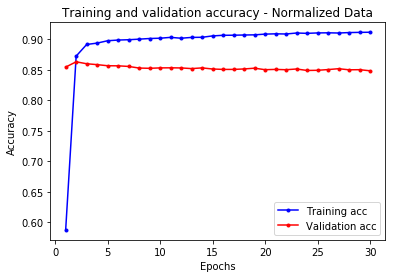

In [15]:
train_hist_norm = train_norm.history
train_acc_norm = train_hist_norm['acc']
val_acc_norm = train_hist_norm['val_acc']
plt.figure()   
num_epochs_norm = range(1, len(train_acc_norm) + 1)
plt.plot(num_epochs_norm, train_acc_norm, 'b.-', label='Training acc')
plt.plot(num_epochs_norm, val_acc_norm, 'r.-', label='Validation acc')
plt.title('Training and validation accuracy - Normalized Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Min-Max Scaled Data

In [8]:
X_tr_mm = preprocessing.minmax_scale(X_train, feature_range=(0,1))
X_te_mm = preprocessing.minmax_scale(X_test, feature_range=(0,1))
X_va_mm = preprocessing.minmax_scale(X_val, feature_range=(0,1))

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [11]:
num_features = len(bad_words)

modem_mm = keras.Sequential()
modem_mm.add(keras.layers.Dense(units=num_features, input_shape=(num_features,)))
modem_mm.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid))
modem_mm.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid))
modem_mm.add(keras.layers.Dense(units=1, activation=tf.nn.sigmoid))
modem_mm.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['acc'])
modem_mm.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5213)              27180582  
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              7821000   
_________________________________________________________________
dense_2 (Dense)              (None, 1500)              2251500   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1501      
Total params: 37,254,583
Trainable params: 37,254,583
Non-trainable params: 0
_________________________________________________________________


In [12]:
train_mm = modem_mm.fit(X_tr_mm,
                        Y_train, 
                        epochs=30, 
                        batch_size=500, 
                        validation_data=(X_va_mm, Y_val), 
                        verbose=1)

Train on 15000 samples, validate on 15000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 1.2916 - acc: 0.5015 - val_loss: 0.7541 - val_acc: 0.5000
Epoch 2/30
15000/15000 [==============================] - 27s 2ms/sample - loss: 0.6500 - acc: 0.5937 - val_loss: 0.5890 - val_acc: 0.6785
Epoch 3/30
15000/15000 [==============================] - 27s 2ms/sample - loss: 0.5168 - acc: 0.7373 - val_loss: 0.5860 - val_acc: 0.7008
Epoch 4/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 0.4706 - acc: 0.7730 - val_loss: 0.5976 - val_acc: 0.7293
Epoch 5/30
15000/15000 [==============================] - 27s 2ms/sample - loss: 0.4445 - acc: 0.7866 - val_loss: 0.6200 - val_acc: 0.7347
Epoch 6/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.4241 - acc: 0.7950 - val_loss: 0.6441 - val_acc: 0.7405
Epoch 7/30
15000/15000 [==============================] - 30s 2ms/sa

In [13]:
results = modem_mm.evaluate(X_te_mm, Y_test)
print(results)

30000/30000 [==============================] - 24s 801us/sample - loss: 1.2001 - acc: 0.8747
[1.200053024037679, 0.8746667]


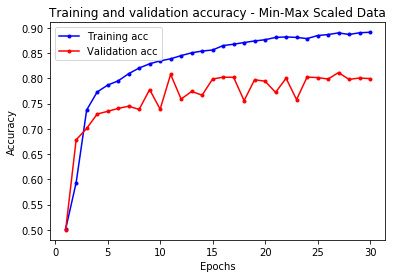

In [14]:
train_hist_mm = train_mm.history
train_acc_mm = train_hist_mm['acc']
val_acc_mm = train_hist_mm['val_acc']
plt.figure()   
num_epochs_mm = range(1, len(train_acc_mm) + 1)
plt.plot(num_epochs_mm, train_acc_mm, 'b.-', label='Training acc')
plt.plot(num_epochs_mm, val_acc_mm, 'r.-', label='Validation acc')
plt.title('Training and validation accuracy - Min-Max Scaled Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()